In [ ]:
import sys
sys.path.append('/work/')
from dCSFA_NMF import dCSFA_NMF
import umc_data_tools as umc_dt

import os
import re
import pickle
import math

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from pycirclize import Circos
from pycirclize.utils import ColorCycler

In [ ]:
# select network number
NETWORK_NUM = 0

# select only the top strongest connections
COH_THRESHOLD = 0.8

In [ ]:
# import data from pkl file
with open('electome_network_lst.pkl', 'rb') as f:
    electome_network_lst = pickle.load(f)

areas = ['BLA', 'LH', 'MD', 'mPFC', 'vHPC']

# Convert chromosome dataframe to the format required by Circos
sector_sizes = {
    'BLA':56, 
    'LH':56, 
    'MD':56,
    'mPFC':56,
    'vHPC':56
}

In [ ]:
# select only part of the dataframe
def select_network(dataframe_lst, network_num, network_component="pow"):
    match_substring = network_component
    network_df = dataframe_lst[network_num]
    trim_df = network_df[network_df.columns[network_df.columns.str.contains(match_substring)]]
    trim_df.columns = trim_df.columns.str.replace(match_substring+"_", '')
    return trim_df

# get the power dataframe
power_df = select_network(electome_network_lst, NETWORK_NUM, 'pow')
# get the coherence dataframe
coherence_df = select_network(electome_network_lst, NETWORK_NUM, 'coh')

In [ ]:
# convert coherence dataframe to the format required by Circos
link_df = pd.melt(
    coherence_df, 
    value_vars=coherence_df.columns,
    var_name='brain_areas', 
    value_name='coherence'
)
link_df[['brain_area1', 'brain_area2']] = link_df['brain_areas'].str.split('-', expand=True)
repeat_times = int(len(link_df) / 56)
link_df['frequency'] = np.tile(np.arange(1, 57), repeat_times)
link_df = link_df[link_df['coherence'] > COH_THRESHOLD]

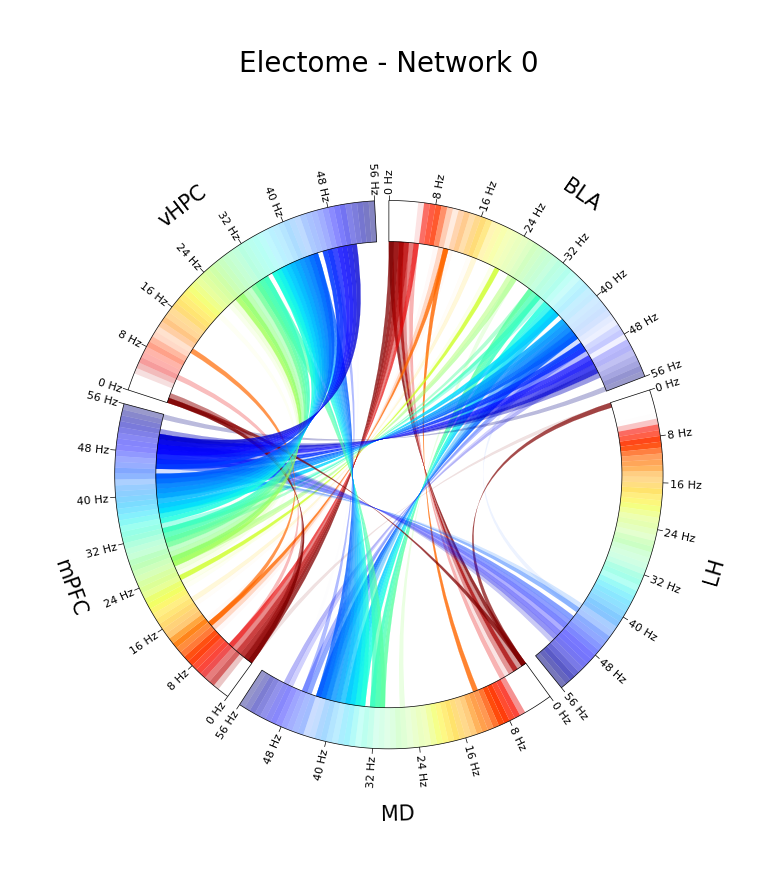

In [ ]:
# Initialize Circos from the chromosome sizes
circos = Circos(sector_sizes, space=3)
circos.text(f"Electome - Network {NETWORK_NUM}", size=20, r=150)

# Create a color mapping for chromosomes
ColorCycler.set_cmap("jet")
freq_colors = ColorCycler.get_color_list(56)
freq_colors.reverse()

# Plot chromosome names and xticks
for sector in circos.sectors:
    sector.text(sector.name, r=120, size=15, color='black')
    outer_track = sector.add_track((85, 100))
    outer_track.axis()
    outer_track.xticks_by_interval(
        8, 
        label_size=8, 
        label_orientation="vertical", 
        label_formatter=lambda v: f"{v / 1:.0f} Hz"
    )

    for i in range(int(outer_track.size)):
        start, end = i, i + 1
        outer_track.rect(start, end, fc=freq_colors[i], alpha=power_df[sector.name][i]) # set power to alpha

# Plot the links from the link dataframe
# coherence is a link
for _, row in link_df.iterrows():
    region1 = (row['brain_area1'], row['frequency']-1, row['frequency'])
    region2 = (row['brain_area2'], row['frequency']-1, row['frequency'])
    color = "black"
    circos.link(
        region1, 
        region2,
        color=freq_colors[int(row['frequency']-1)],
        alpha=(row['coherence']-COH_THRESHOLD)*(1/(1-COH_THRESHOLD)) # set coherence to alpha
    )

# Plot the Circos figure
fig = circos.plotfig()

# Display the plot
fig.show()

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=d14e702a-7f9c-48a2-8d79-c67c05798ffa' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>